In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Reverse_Dipole_Array/libs')

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
from DataCaller import DataCaller
from EarlyStopper import *
from Net import *
from train_test import *
from utils import *

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = True
BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
LEARNING_RATE = 1.5e-5
EPOCHS = 10
PATIENCE = 6
VALIDATE_EVERY = 10
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64
IMG_CHANNELS = 4
LABEL_SIZE = 4
OUTPUT_AB = 2
OUTPUT_DT = 2


BASE_PATH = '/content/gdrive/My Drive/Colab Notebooks/Reverse_Dipole_Array/data'
TRAIN_DATA_PATH = os.path.join(BASE_PATH, 'coding/train')
VAL_DATA_PATH = os.path.join(BASE_PATH, 'coding/val')
TEST_DATA_PATH = os.path.join(BASE_PATH, 'coding/test')


cuda


In [4]:
if LOAD_DATA:
    trainsets = []
    valsets = []
    testsets = []
    for f in tqdm(os.listdir(TRAIN_DATA_PATH)):
      path = os.path.join(TRAIN_DATA_PATH, f)
      trainset = DataCaller(path, IMG_SIZE, LABEL_SIZE)
      print(trainset.__len__())
      trainsets.append(trainset)

    for f in tqdm(os.listdir(VAL_DATA_PATH)):
      path  = os.path.join(VAL_DATA_PATH, f)
      valset = DataCaller(path, IMG_SIZE, LABEL_SIZE)
      print(valset.__len__())
      valsets.append(valset)

    for f in tqdm(os.listdir(TEST_DATA_PATH)):
      path  = os.path.join(TEST_DATA_PATH, f)
      testset = DataCaller(path, IMG_SIZE, 3)
      print(testset.__len__())
      testsets.append(testset)

    trainset = ConcatDataset(trainsets)
    print(trainset.__len__())
    valset = ConcatDataset(valsets)
    print(valset.__len__())
    testset = ConcatDataset(testsets)
    print(testset.__len__())  

  0%|          | 0/1 [00:00<?, ?it/s]

624


  0%|          | 0/1 [00:00<?, ?it/s]

624


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]

124
624
624
124


In [0]:
  #define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [6]:
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    filter_input(x)
    x = np.array(x)
    x = x.reshape(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)

    print(x[0])
    print(x[0].shape)

    print(y[0])
    cnt += 1
    if cnt==1:
      break

[[[7.6631   7.6518   7.636    ... 0.       0.       0.      ]
  [7.6631   7.6538   7.6398   ... 0.       0.       0.      ]
  [7.6631   7.6557   7.6432   ... 0.       0.       0.      ]
  ...
  [7.6631   7.6477   7.6273   ... 0.       0.       0.      ]
  [7.6631   7.6498   7.6318   ... 0.       0.       0.      ]
  [7.6631   7.6518   7.636    ... 0.       0.       0.      ]]

 [[7.3025   7.3775   7.4405   ... 0.29131  0.065375 0.      ]
  [7.3025   7.3746   7.4348   ... 0.34841  0.1261   0.      ]
  [7.3025   7.371    7.4281   ... 0.99984  0.79182  0.58077 ]
  ...
  [7.3025   7.3814   7.4488   ... 1.2781   1.0673   0.85379 ]
  [7.3025   7.3798   7.4452   ... 0.88071  0.66491  0.44607 ]
  [7.3025   7.3775   7.4405   ... 0.29131  0.065375 0.      ]]

 [[6.1332   6.3261   6.4967   ... 3.364    3.1452   2.9207  ]
  [6.1332   6.317    6.4792   ... 3.405    3.1895   2.9684  ]
  [6.1332   6.3064   6.4599   ... 3.7785   3.5718   3.3601  ]
  ...
  [6.1332   6.3398   6.5253   ... 3.92     3.707

 10%|█         | 1/10 [00:00<00:06,  1.29it/s]


loss :  204.9698732816256 val loss :  204.33233955578928 

Validation loss decreased (inf --> 204.332340).  Saving model ...


 20%|██        | 2/10 [00:01<00:06,  1.29it/s]


loss :  203.42538452148438 val loss :  202.15337939140124 

Validation loss decreased (204.332340 --> 202.153379).  Saving model ...


 30%|███       | 3/10 [00:02<00:05,  1.29it/s]


loss :  200.15140513884717 val loss :  197.49557103866186 

Validation loss decreased (202.153379 --> 197.495571).  Saving model ...


 40%|████      | 4/10 [00:03<00:04,  1.28it/s]


loss :  192.6869659423828 val loss :  185.61741012181992 

Validation loss decreased (197.495571 --> 185.617410).  Saving model ...


 50%|█████     | 5/10 [00:03<00:03,  1.29it/s]


loss :  171.51949955866888 val loss :  150.7078342926808 

Validation loss decreased (185.617410 --> 150.707834).  Saving model ...


 60%|██████    | 6/10 [00:04<00:03,  1.28it/s]


loss :  116.54068237695938 val loss :  75.69714189187074 

Validation loss decreased (150.707834 --> 75.697142).  Saving model ...


 70%|███████   | 7/10 [00:05<00:02,  1.26it/s]


loss :  43.56692084287986 val loss :  21.120300561953815 

Validation loss decreased (75.697142 --> 21.120301).  Saving model ...


 80%|████████  | 8/10 [00:06<00:01,  1.27it/s]


loss :  16.604691872229942 val loss :  14.32428335532164 

Validation loss decreased (21.120301 --> 14.324283).  Saving model ...


 90%|█████████ | 9/10 [00:07<00:00,  1.28it/s]


loss :  14.129913403437687 val loss :  13.98813321040227 

Validation loss decreased (14.324283 --> 13.988133).  Saving model ...


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


loss :  13.922901459229298 val loss :  13.78399301186586 

Validation loss decreased (13.988133 --> 13.783993).  Saving model ...


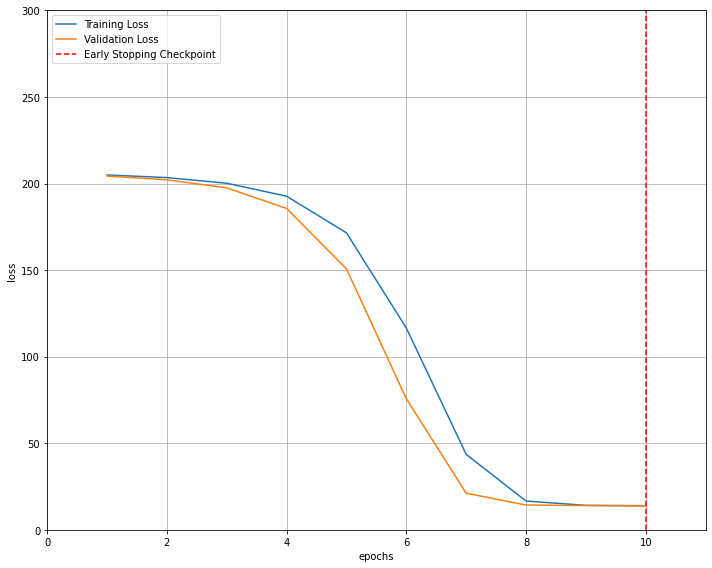

In [7]:
net = Net(IMG_CHANNELS, OUTPUT_AB, OUTPUT_DT)
net.to(device)
train_losses, valid_losses = train(net, trainloader, valloader, EPOCHS, LEARNING_RATE, IMG_CHANNELS, IMG_SIZE, MODEL_NAME, PATIENCE, VALIDATE_EVERY, device)
save_plot(train_losses, valid_losses)

In [8]:
test(net, testloader, IMG_CHANNELS, IMG_SIZE, LABEL_SIZE, device)

[array([[8.949223  , 9.31166   , 5.108277  , 0.58993804]], dtype=float32), array([[8.967976 , 9.274799 , 5.1120353, 0.5937059]], dtype=float32), array([[8.667196 , 8.843078 , 4.8547835, 0.5820844]], dtype=float32), array([[8.330844, 8.381763, 4.576059, 0.545877]], dtype=float32), array([[7.8242435, 7.9920993, 4.323017 , 0.5237787]], dtype=float32), array([[8.994916 , 9.38614  , 5.1796184, 0.5898806]], dtype=float32), array([[9.082541  , 9.397198  , 5.196198  , 0.60570073]], dtype=float32), array([[8.61368  , 8.809152 , 4.8469005, 0.5810103]], dtype=float32), array([[8.382078 , 8.462321 , 4.633162 , 0.5501099]], dtype=float32), array([[8.373764  , 8.541685  , 4.630031  , 0.54525113]], dtype=float32), array([[9.1550665 , 9.559142  , 5.291545  , 0.59111255]], dtype=float32), array([[9.111608 , 9.435258 , 5.2320323, 0.6123256]], dtype=float32), array([[8.640912 , 8.842194 , 4.8787146, 0.5854211]], dtype=float32), array([[8.333948  , 8.431653  , 4.6237545 , 0.54864407]], dtype=float32), arr